 ## C add attributes 2 and begin feat engineering
 Design matrix is one record per row


In [1]:
# formatting
import jupyter_black

jupyter_black.load(
    lab=False,
)

<IPython.core.display.Javascript object>

In [2]:
# imports

import pandas as pd
import numpy as np  # for np.nan
import os  # for path

import yfinance as yf

import json

from pandas_datareader.quandl import QuandlReader  # data side

reload_data = True
end_date = "2030-12-31"

In [3]:
with open("data/vars.json", "r") as json_file:
    var_dict = json.load(json_file)

In [4]:
# read in raw data
### INPUT ###

# formatted tradelog
trades_filename = "output/b_completewattr.csv"
df_raw = pd.read_csv(trades_filename)

### Existing Cols with Issues

In [5]:
existing_err_cols = [
    "AAII_SENT_Date",
    "AAII_SENT_Bullish",  ## AAII columns are missing later 2021 and 2022 values
    "AAII_SENT_Neutral",
    "AAII_SENT_Bearish",
    "AAII_SENT_Total",
    "AAII_SENT_Bullish8WeekMovAvg",
    "AAII_SENT_BullBearSpread",
    "AAII_SENT_BullishAverage",
    "AAII_SENT_BullishAverage+StDev",
    "AAII_SENT_BullishAverageStDev",
    "AAII_SENT_S&P500WeeklyHigh",
    "AAII_SENT_S&P500WeeklyLow",
    "AAII_SENT_S&P500WeeklyClose",
]

## pull data from yahoo finance

In [6]:
tickers = ["^VIX", "^GSPC"]
if reload_data:
    df_data = yf.download(
        " ".join(tickers), start="2010-01-01", end=end_date, group_by="Tickers"
    )
    # turn into tabular form
    df_data_formatted = (
        df_data.stack(level=0).reset_index().rename(columns={"level_1": "Ticker"})
    )
    df_data_formatted.to_csv("output/c_mktdata.csv")
else:
    df_data_formatted = pd.read_csv("output/c_mktdata.csv")

df_data_formatted.head()

[                       0%                       ]

[*********************100%***********************]  2 of 2 completed

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,^GSPC,1132.989990,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
1,2010-01-04,^VIX,20.040001,20.040001,21.680000,20.030001,21.680000,0
2,2010-01-05,^GSPC,1136.520020,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
3,2010-01-05,^VIX,19.350000,19.350000,20.129999,19.340000,20.049999,0
4,2010-01-06,^GSPC,1137.140015,1137.140015,1139.189941,1133.949951,1135.709961,4972660000


In [7]:
# pivoted

df_data_pivot = df_data_formatted.pivot(
    index=["Date"],
    columns=["Ticker"],
    values=["Close"],
).reset_index()

# to deal with multiindex columns
df_data_pivot.columns = ["_".join(col).strip() for col in df_data_pivot.columns.values]
df_data_pivot.rename(columns={'Date_':'Date_YahooFinance'}, inplace=True)
df_data_pivot["Date_YahooFinance"] = pd.to_datetime(df_data_pivot["Date_YahooFinance"], errors="coerce")
df_data_pivot.head()

,Date_YahooFinance,Close_^GSPC,Close_^VIX
0,2010-01-04,1132.989990,20.040001
1,2010-01-05,1136.520020,19.350000
2,2010-01-06,1137.140015,19.160000
3,2010-01-07,1141.689941,19.059999
4,2010-01-08,1144.979980,18.129999


In [8]:
# merge

df_source = df_raw.copy(deep=True)

df_source["Open_Date"] = pd.to_datetime(df_source["Open_Date"], errors="coerce")


# need to sort
df_source = df_source.sort_values(["Open_Date"])
df_data_pivot = df_data_pivot.sort_values(["Date_YahooFinance"])

df_result = pd.merge_asof(
    df_source, df_data_pivot, left_on=["Open_Date"], right_on=["Date_YahooFinance"]
)

### Add Open Year

In [9]:
df_result["Open_Year"] = df_result["Open_Date"].dt.year

### Test data

In [10]:
df_result.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Open_Date', 'Close_Date', 'Symbol',
       'Quantity', 'Pnl', 'OpenAct', 'CloseAct', 'Open_Price', 'Close_Price',
       'Comm_Tot', 'DATE', 'ACTION', 'QTYCHG', 'PRICE', 'TIME', 'UNNAMED: 6',
       'COMMISSION', 'UNNAMED: 8', 'CASH CHG (PNL)', 'COMMENTS', 'PCTRETURN',
       'DETAILS', 'STARTDATE', 'COMPANY NAME (IN ALPHABETICAL ORDER)',
       'TICKER', 'STOP', '% TO STOP', 'CURRENT PRICE', '% TO TARGET',
       'AT PRICE', 'TARGET', 'EPS1', 'EPS2', 'FYEND', 'DAYSTOFYEND',
       'FYEPSNXT', 'GROWTH*0.5TO0.75', 'ROIC (BW ROA ROE)', 'TGT FWD P/E',
       'YEARS TO NORMALIZATION', 'LASTUPDATED', 'CATEGORY', 'COMMENTS.1',
       'FILENAME', 'DayOfWeek0Mon', 'Date_YahooFinance', 'Close_^GSPC',
       'Close_^VIX', 'Open_Year'],
      dtype='object')

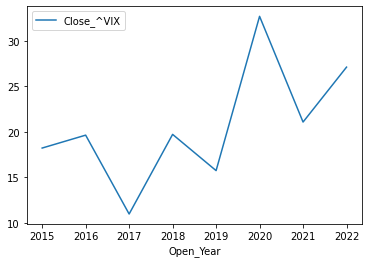

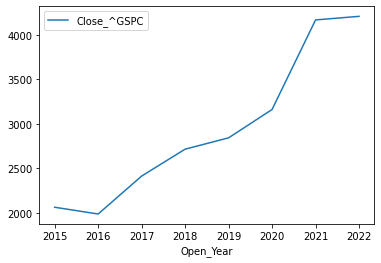

In [11]:
for symbol in tickers:
    temp_df = pd.pivot_table(
        df_result,
        index=["Open_Year"],
        values="Close_" + symbol,
        aggfunc="mean",
        dropna=False,
    )
    temp_df.plot()

    assert min(temp_df["Close_" + symbol]) > 0, "values should all be above zero"

## pull data from Quandl  / Nasdaq Data Link
1. log in is from [Nasdaq data link](https://docs.data.nasdaq.com/docs/python-installation)

In [12]:
externalvar_dict = {
    "AAII/AAII_SENTIMENT": "AAII_SENT",  ## aaii sentiment
    #     "FED/RIMLPAAAR_N_B": "FED_AAACORP",  ## daily Fed AAA rates #TODO ned to fix different timeframes
}

In [13]:
# import nasdaqdatalink

# NASDAQ_DATA_LINK_API_KEY = var_dict["NASDAQ_DATA_LINK_API_KEY"]
# data = nasdaqdatalink.get("AAII/AAII_SENTIMENT", start_date="2015-01-01", end_date="2030-12-31")

In [14]:
externalvar_dict = {
    "AAII/AAII_SENTIMENT": "AAII_SENT",  ## aaii sentiment
    #     "FED/RIMLPAAAR_N_B": "FED_AAACORP",  ## daily Fed AAA rates #TODO ned to fix different timeframes
}

In [15]:
if reload_data:

    #     df_varlist = []

    for variable, value in externalvar_dict.items():

        quandl_key = var_dict["QUANDL_API"]

        QR = QuandlReader(variable, api_key=quandl_key, start="1/1/2015", end=end_date)

        QR_df = QR.read().reset_index()

        QR_df.columns = [
            value + "_" + str(col)  # if col.upper() != "DATE" else col
            for col in QR_df.columns
        ]

        #         df_varlist.append(QR_df)

        # merge Quandl
        QR_df_sorted = QR_df.sort_values([f"{value}_Date"])
        QR_df_sorted["Date"] = pd.to_datetime(QR_df[f"{value}_Date"], errors="coerce")

        df_result = pd.merge_asof(
            df_result,
            QR_df_sorted,
            left_on=["Open_Date"],
            right_on=[f"{value}_Date"],
            direction="forward",
        )

        #     QR_df = pd.concat(
        #         [df.set_index("Date") for df in df_varlist], axis=1, join="outer"
        #     ).reset_index()
        QR_df.to_csv(f"output/c_quandl_{value}.csv")
else:
    for variable, value in externalvar_dict.items():

        QR_df = pd.read_csv(f"output/c_quandl_{value}.csv")

        # merge Quandl
        QR_df_sorted = QR_df.sort_values(["Date"])
        QR_df_sorted["Date"] = pd.to_datetime(QR_df[f"{value}_Date"], errors="coerce")

        df_result = pd.merge_asof(
            df_result,
            QR_df_sorted,
            left_on=["Open_Date"],
            right_on=[f"{value}_Date"],
            direction="forward",
        )

In [16]:
QR_df.head()

,AAII_SENT_Date,AAII_SENT_Bullish,AAII_SENT_Neutral,AAII_SENT_Bearish,AAII_SENT_Total,AAII_SENT_Bullish8WeekMovAvg,AAII_SENT_BullBearSpread,AAII_SENT_BullishAverage,AAII_SENT_BullishAverage+StDev,AAII_SENT_BullishAverageStDev,AAII_SENT_S&P500WeeklyHigh,AAII_SENT_S&P500WeeklyLow,AAII_SENT_S&P500WeeklyClose
0,2021-04-22,0.526814,0.268139,0.205047,1.0,0.462819,0.321767,0.380245,0.480891,0.279599,4170.46,4160.11,4162.43
1,2021-04-15,0.538206,0.215947,0.245847,1.0,0.460250,0.292359,0.380245,0.480891,0.279599,4151.69,4120.87,4124.66
2,2021-04-08,0.569079,0.226974,0.203947,1.0,0.457611,0.365132,0.380245,0.480891,0.279599,4093.87,4089.89,4091.04
3,2021-04-01,0.458333,0.309524,0.232143,1.0,0.451054,0.226190,0.380245,0.480891,0.279599,4013.04,4013.04,4013.04
4,2021-03-25,0.509494,0.284810,0.205696,1.0,0.450599,0.303798,0.380245,0.480891,0.279599,3887.14,3864.63,3881.20


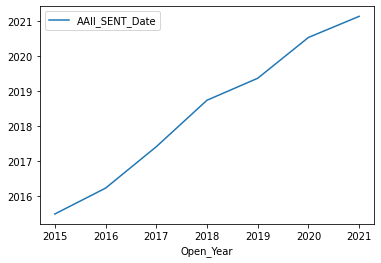

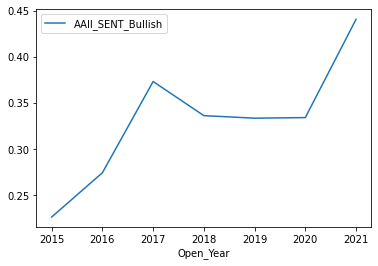

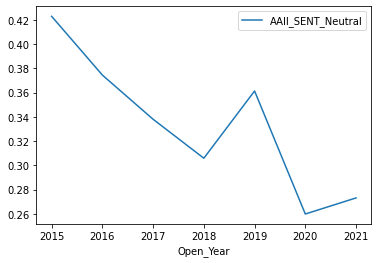

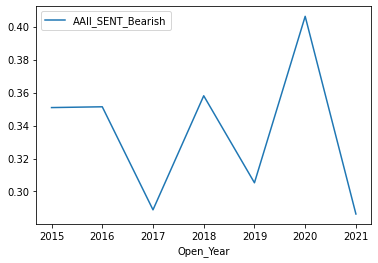

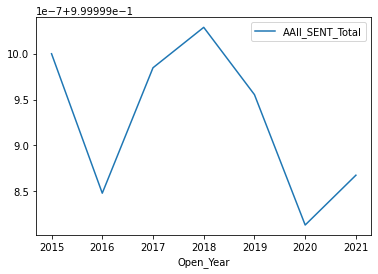

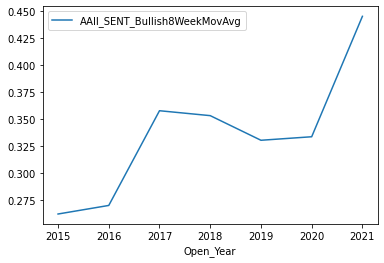

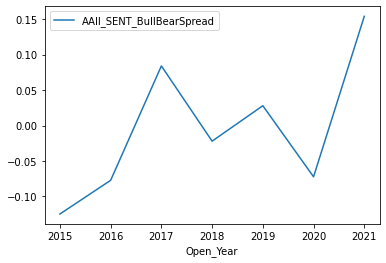

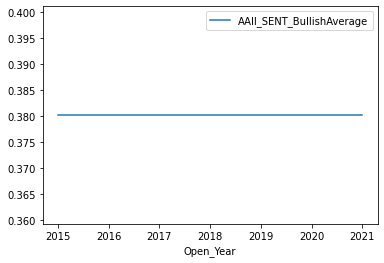

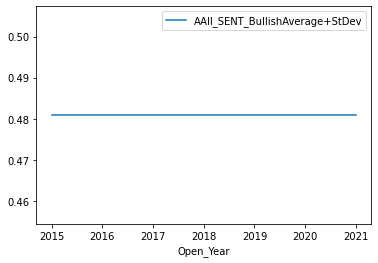

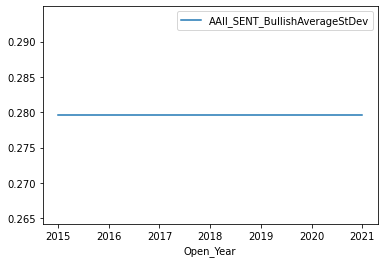

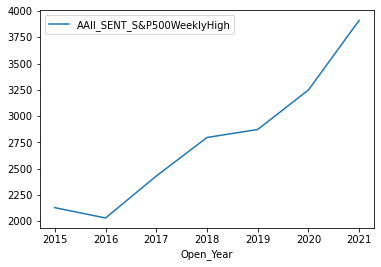

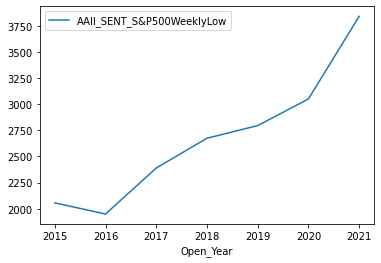

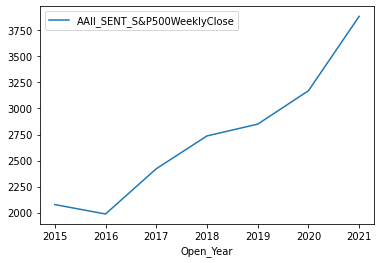

In [17]:
cols_with_errors = []

for variable, value in externalvar_dict.items():
    for c in df_result.columns:
        if value in c:
            temp_df = pd.pivot_table(
                df_result, index=["Open_Year"], values=c, aggfunc="mean", dropna=False
            )
            temp_df.plot()

            try:
                assert sum(temp_df[c].isna()) == 0, "values should all be filled"
            except:
                cols_with_errors.append(c)

In [18]:
cols_with_errors

['AAII_SENT_Date',
 'AAII_SENT_Bullish',
 'AAII_SENT_Neutral',
 'AAII_SENT_Bearish',
 'AAII_SENT_Total',
 'AAII_SENT_Bullish8WeekMovAvg',
 'AAII_SENT_BullBearSpread',
 'AAII_SENT_BullishAverage',
 'AAII_SENT_BullishAverage+StDev',
 'AAII_SENT_BullishAverageStDev',
 'AAII_SENT_S&P500WeeklyHigh',
 'AAII_SENT_S&P500WeeklyLow',
 'AAII_SENT_S&P500WeeklyClose']

In [19]:
temp_df

,AAII_SENT_S&P500WeeklyClose
Open_Year,
2015,2077.420000
2016,1986.630368
2017,2421.097551
2018,2736.441442
2019,2849.521399
2020,3170.192446
2021,3884.754898
2022,NaN


In [20]:
# check diff
assert len(set(cols_with_errors).difference(set(existing_err_cols))) == 0, "new errors"

## Final Checks

In [21]:
df_result.loc[0, df_result.columns.duplicated()]

Series([], Name: 0, dtype: object)

In [22]:
assert len(df_result.loc[0, df_result.columns.duplicated()]) == 0, "duplicates"

## Save Output

In [23]:
df_result.to_csv("output/c_resulttradewattr.csv")